<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter03/Steps_to_build_a_neural_network_on_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
#data_folder = '~/data/FMNIST' #This can be any directory you want to 
# download FMNIST to
fmnist = datasets.FashionMNIST("../data/FMNIST/", train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [4]:
tr_images
.shape

torch.Size([60000, 28, 28])

In [11]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

In [12]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

In [ ]:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of     
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where 
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides 
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


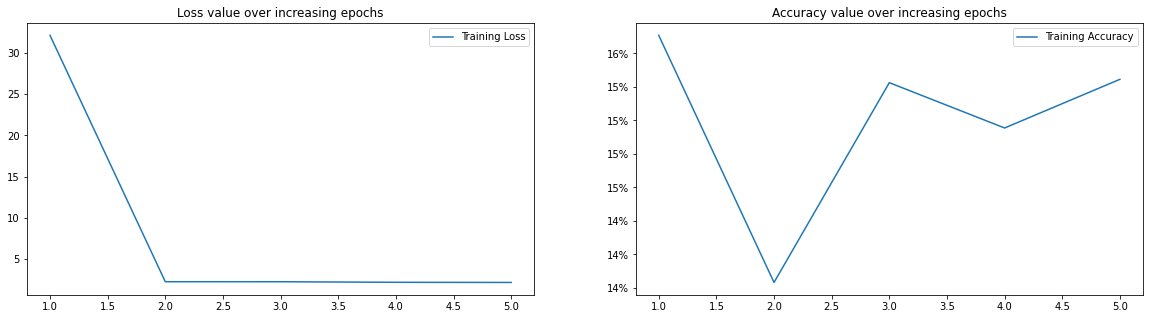

In [ ]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

## My implementation

In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
from torch.optim import SGD

In [2]:
fmnist = datasets.FashionMNIST("../data/FMNIST/", train=True)

In [3]:
type(fmnist)

torchvision.datasets.mnist.FashionMNIST

In [4]:
tr_images = fmnist.data
tr_labels = fmnist.targets

In [5]:
tr_images.shape

torch.Size([60000, 28, 28])

In [24]:
class FMNIST(Dataset):
    def __init__(self, x, y):
        self.x = x.float() / 255
        self.x = self.x.view(-1, 28*28)
        self.y = y

    def __getitem__(self, ix):
        return self.x[ix], self.y[ix] 

    def __len__(self):
        return len(self.x)

In [25]:
fmnist_dataset = FMNIST(tr_images, tr_labels)

In [26]:
trn_dl = DataLoader(fmnist_dataset, batch_size = 32, shuffle=True)

In [27]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000), 
        nn.ReLU(), 
        nn.Linear(1000, 10)
    )
    loss_fun = nn.CrossEntropyLoss()
    opt = SGD(model.parameters(), lr = 1e-2)

    return model, loss_fun, opt

In [28]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() 

    prediction = model(x)

    loss_value = loss_fn(prediction, y)

    loss_value.backward()

    opt.step()

    opt.zero_grad()

    return loss_value.item()

In [29]:
@torch.no_grad()
def accuracy(x, y, model): 
    model.eval()

    prediction = model(x) 

    max_values, argmaxes = prediction.max(-1)

    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

In [30]:
#trn_dl = get_data()
model, loss_fn, optimizer = get_model()

In [31]:
losses, accuracies = [], [] 

for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuries = [], []

    for batch_idx, batch in enumerate(iter(trn_dl)):
        x, y = batch 

        x, y = x.to(device), y.to(device)

        loss = train_batch(x, y, model, optimizer, loss_fn)

        epoch_losses.append(loss)
        
    epoch_loss = np.array(epoch_losses).mean()

    for batch_idx, batch in enumerate(iter(trn_dl)):
        x, y = batch 

        is_correct = accuracy(x, y, model)

        epoch_accuries.extend(is_correct)

    epoch_accurary = np.mean(epoch_accuries)

    losses.append(epoch_loss)
    accuracies.append(epoch_accurary)

        

0
1
2
3
4


/var/folders/r4/rydmyytn6q1fyl58zgvg8qp80000gn/T/ipykernel_31026/1668084199.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


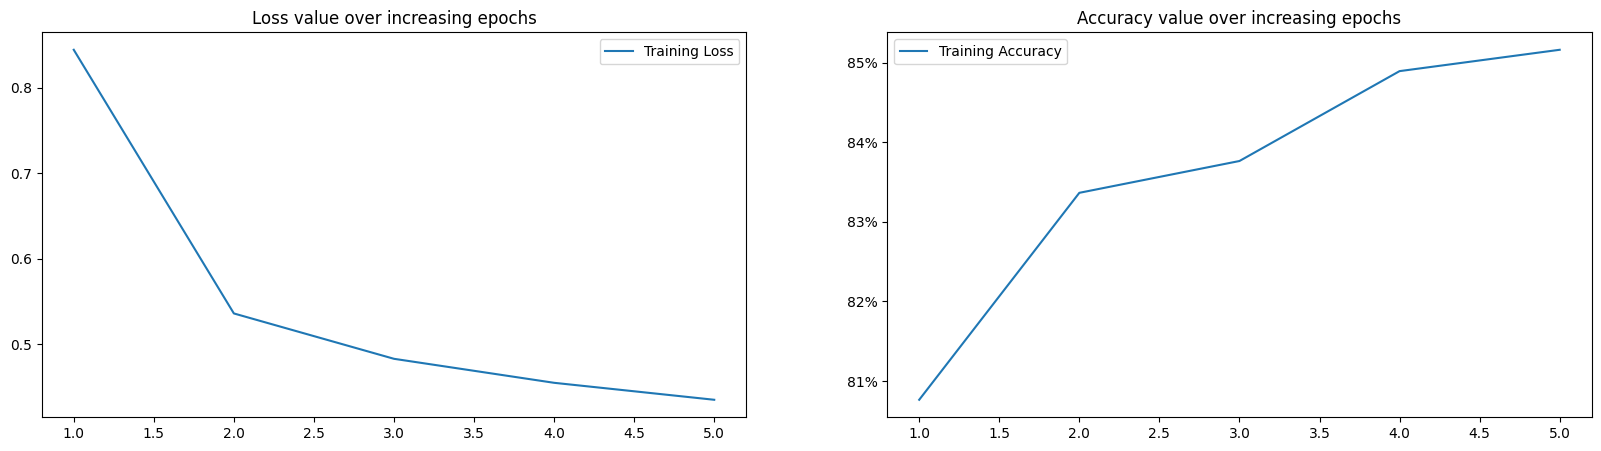

In [32]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()

## Varying batch size 

## Data is split into train and test 

In [36]:
fmnist = datasets.FashionMNIST("../data/FMNIST/train", download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

100.0%


Extracting ../data/FMNIST/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FMNIST/train/FashionMNIST/raw



100.0%


Extracting ../data/FMNIST/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FMNIST/train/FashionMNIST/raw



100.0%


Extracting ../data/FMNIST/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FMNIST/train/FashionMNIST/raw



100.0%

Extracting ../data/FMNIST/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FMNIST/train/FashionMNIST/raw



In [39]:
val_fmnist = datasets.FashionMNIST("../data/FMNIST/val", download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [62]:
def get_data(batch_size = 32):
    train_dataset = FMNIST(tr_images, tr_targets)
    train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

    val_dataset = FMNIST(val_images, val_targets)

    val_dl = DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)

    return train_dl, val_dl

In [63]:
train_dl, val_dl = get_data(batch_size = 10000)

In [65]:
for train_idx, batch in enumerate(iter(train_dl)):
    temp = batch 
    break

In [67]:
temp[0].shape

torch.Size([10000, 784])

In [58]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [59]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


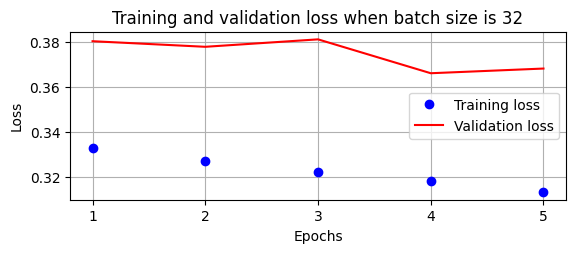

/var/folders/r4/rydmyytn6q1fyl58zgvg8qp80000gn/T/ipykernel_31026/1316040814.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


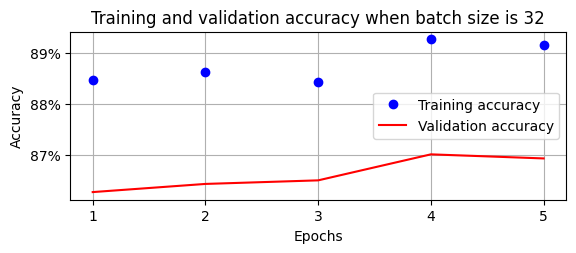

In [61]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()